In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Guangzhou = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/GuangzhouPM20100101_20151231.csv")


In [3]:
#Delet non-useful data
##Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
##               axis=1,
##              inplace=True)

In [4]:
Guangzhou.dropna(axis=0, how="any",inplace=True)

In [6]:
# from datetime import datetime
Guangzhou['Time'] = pd.to_datetime(Guangzhou['year'].map(str) +"/"+ Guangzhou['month'].map(str) +"/"+ Guangzhou['day'].map(str)+" "+Guangzhou['hour'].map(str)+":00:00")
#Beijing

In [7]:
Guangzhou.groupby(['year']).size()

year
2013    3863
2014    7884
2015    8327
dtype: int64

In [9]:
by_hour = Guangzhou.groupby(['Time']).mean()
by_hour.head()

,No,year,month,day,hour,season,PM_City Station,PM_5th Middle School,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
Time,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,26305,2013,1,1,0,4.0,83.0,78.0,83.0,3.7,91.0,1014.2,5.0,1.9,0.0,0.0
2013-01-01 01:00:00,26306,2013,1,1,1,4.0,95.0,70.0,95.0,4.2,88.0,1014.2,6.0,3.4,0.0,0.0
2013-01-01 03:00:00,26308,2013,1,1,3,4.0,55.0,66.0,55.0,3.5,76.0,1013.9,7.5,5.8,0.0,0.0
2013-01-01 04:00:00,26309,2013,1,1,4,4.0,60.0,69.0,60.0,2.7,69.0,1013.9,8.0,8.2,0.0,0.0
2013-01-01 05:00:00,26310,2013,1,1,5,4.0,41.0,51.0,41.0,1.5,62.0,1014.2,8.4,9.0,0.0,0.0


In [10]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2015-12-31 13:00:00', '2015-12-31 14:00:00',
               '2015-12-31 15:00:00', '2015-12-31 16:00:00',
               '2015-12-31 17:00:00', '2015-12-31 18:00:00',
               '2015-12-31 19:00:00', '2015-12-31 20:00:00',
               '2015-12-31 21:00:00', '2015-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Time', length=26279, freq='H')


In [11]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2013-01-01 00:00:00   2013-01-01 00:00:00
2013-01-01 01:00:00   2013-01-01 01:00:00
2013-01-01 02:00:00   2013-01-01 02:00:00
2013-01-01 03:00:00   2013-01-01 03:00:00
2013-01-01 04:00:00   2013-01-01 04:00:00
                              ...        
2015-12-31 18:00:00   2015-12-31 18:00:00
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
Freq: H, Name: Time, Length: 26279, dtype: datetime64[ns]

In [22]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [24]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
#data_13

In [16]:
#by_hour

In [20]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20130112030000'))]
data = data.set_index(data.index).asfreq('H')
#data

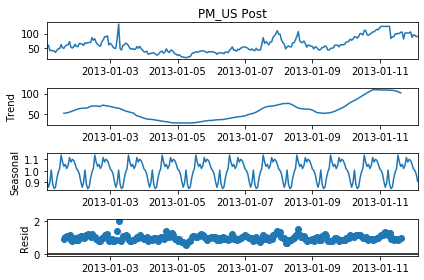

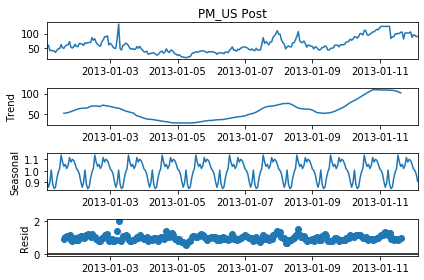

In [18]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [25]:
len(data_13)

730

In [30]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

In [31]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 4, m=7,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=5735.375, BIC=5748.396, Time=0.322 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=5998.993, BIC=6007.674, Time=0.022 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=5790.843, BIC=5808.205, Time=0.355 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=5661.846, BIC=5679.208, Time=0.452 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=5997.396, BIC=6001.736, Time=0.015 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 7) (constant=True); AIC=5955.560, BIC=5968.581, Time=0.231 seconds
Fit ARIMA: (0, 0, 1)x(1, 1, 1, 7) (constant=True); AIC=5662.628, BIC=5684.330, Time=1.008 seconds
Near non-invertible roots for order (0, 0, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 1)x(0, 1, 2, 7) (constant=True); AIC=5663.709, BIC=5685.411, Time=0.846 seconds
Near non-inver

In [32]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  574
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2790.915
Date:                           Fri, 10 Apr 2020   AIC                           5591.831
Time:                                   18:27:29   BIC                           5613.532
Sample:                                        0   HQIC                          5600.300
                                           - 574                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0474      0.034     -1.387      0.165      -0.114       0.020
ar.L1          0.8820      0.029     30.503      0.000       0.825       0.939
ma.L1         -0.5950      0.043    -13.895      0.000      -0.679      -0.511
ma.S.L7       -0.9994      0.995     -1.005      0.315      -2.949       0.950
sigma2      1047.2999   1037.206      1.010      0.313    -985.586    3080.186
===================================================================================
Ljung-Box (Q):                       56.42   Jarque-Bera (JB):              1592.18
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Fit a SARIMAX(1, 0, 1)x(0, 1, 1, 7)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 1),  
                seasonal_order =(0, 1, 1, 7))

In [34]:
result = model.fit() 

In [35]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        PM_US Post   No. Observations:                  574
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2792.922
Date:                           Fri, 10 Apr 2020   AIC                           5593.844
Time:                                   18:27:35   BIC                           5611.205
Sample:                               01-01-2014   HQIC                          5600.619
                                    - 07-28-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8992      0.027     32.860      0.000       0.846       0.953
ma.L1         -0.6086      0.040    -15.063      0.000      -0.688      -0.529
ma.S.L7       -0.9924      0.086    -11.517      0.000      -1.161      -0.823
sigma2      1061.8490     89.397     11.878      0.000     886.634    1237.064
===================================================================================
Ljung-Box (Q):                       56.83   Jarque-Bera (JB):              1627.81
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

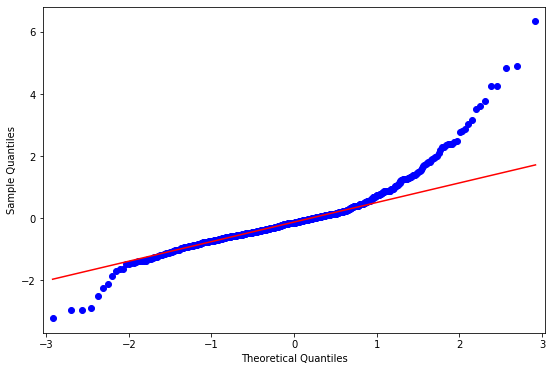

In [36]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

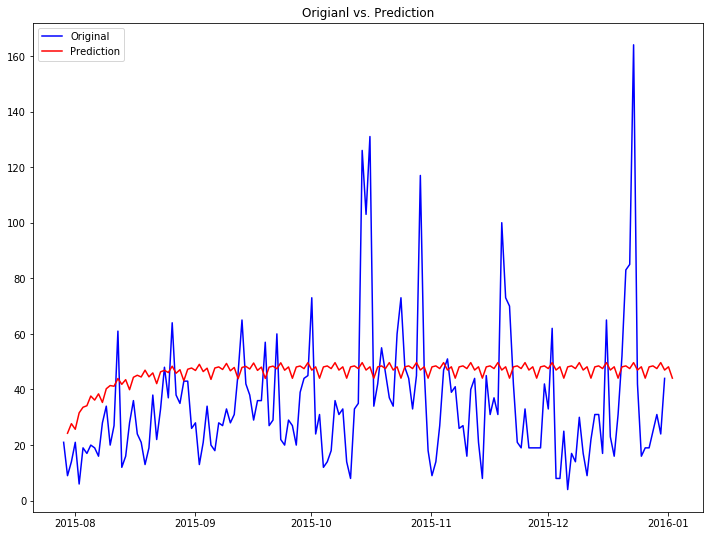

In [37]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 